In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [4]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageH

In [5]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "bias": {}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [6]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*20, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    #"aberrations": opt(g*100,20),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
    "bias": opt(g*30, 20)
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [7]:
losses, models = optimise(params, model_single, exposures_single, things, 30)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[4122124.57153954, -679868.05681793],
       [-679868.05681793, 4092699.06080922]], dtype=float64), 'spectrum': Array([[39825870.30077434,  -395626.89886748, 14555101.02664719,
         -203756.25366979,  9614305.94328543],
       [ -395626.89886748,  4865426.72788169,  -219792.36805538,
         3096988.12464937,  -170934.30690965],
       [14555101.02664719,  -219792.36805538,  6592677.07231386,
         -130512.08190226,  4699124.37228833],
       [ -203756.25366979,  3096988.12464937,  -130512.08190226,
         2330058.7249053 ,  -104022.15887149],
       [ 9614305.94328543,  -170934.30690965,  4699124.37228833,
         -104022.15887149,  3518421.62320282]], dtype=float64), 'cold_mask_shift': Array([[-80787.34850449,   9609.03831762],
       [  9609.03831762, -80638.50160866]], dtype=float64), 'cold_mask_rot': Array([[-145901.32424834]], dtype=float64), 'bias': Array([[8218081.95721834]], dtype=float64)}}
Fitting Model


  0%|          | 0/30 [00:00<?, ?it/s]

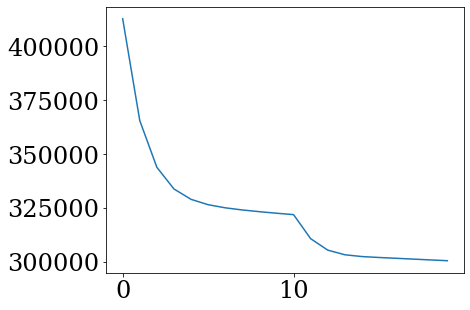

In [8]:
plt.plot(losses[-20:])

5


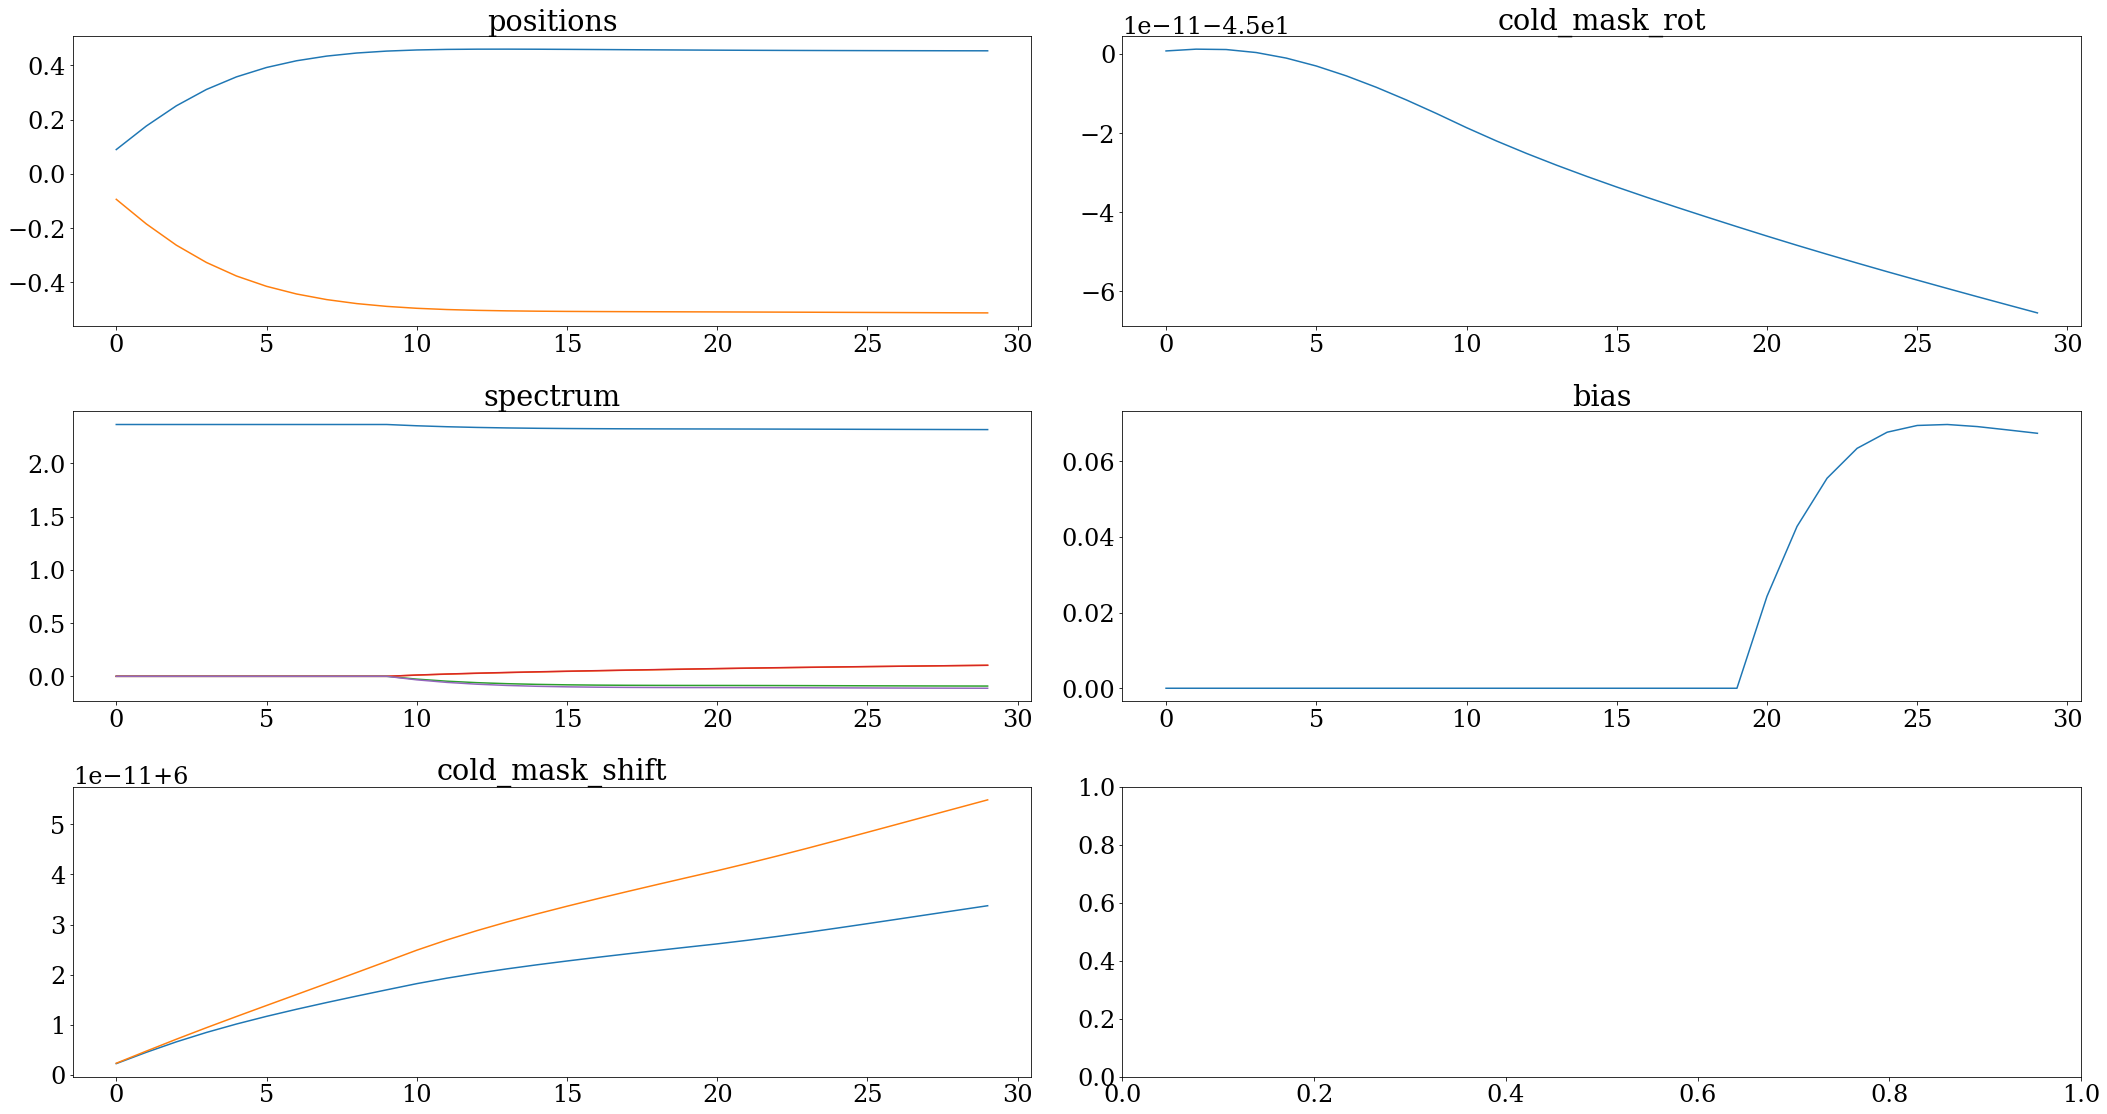

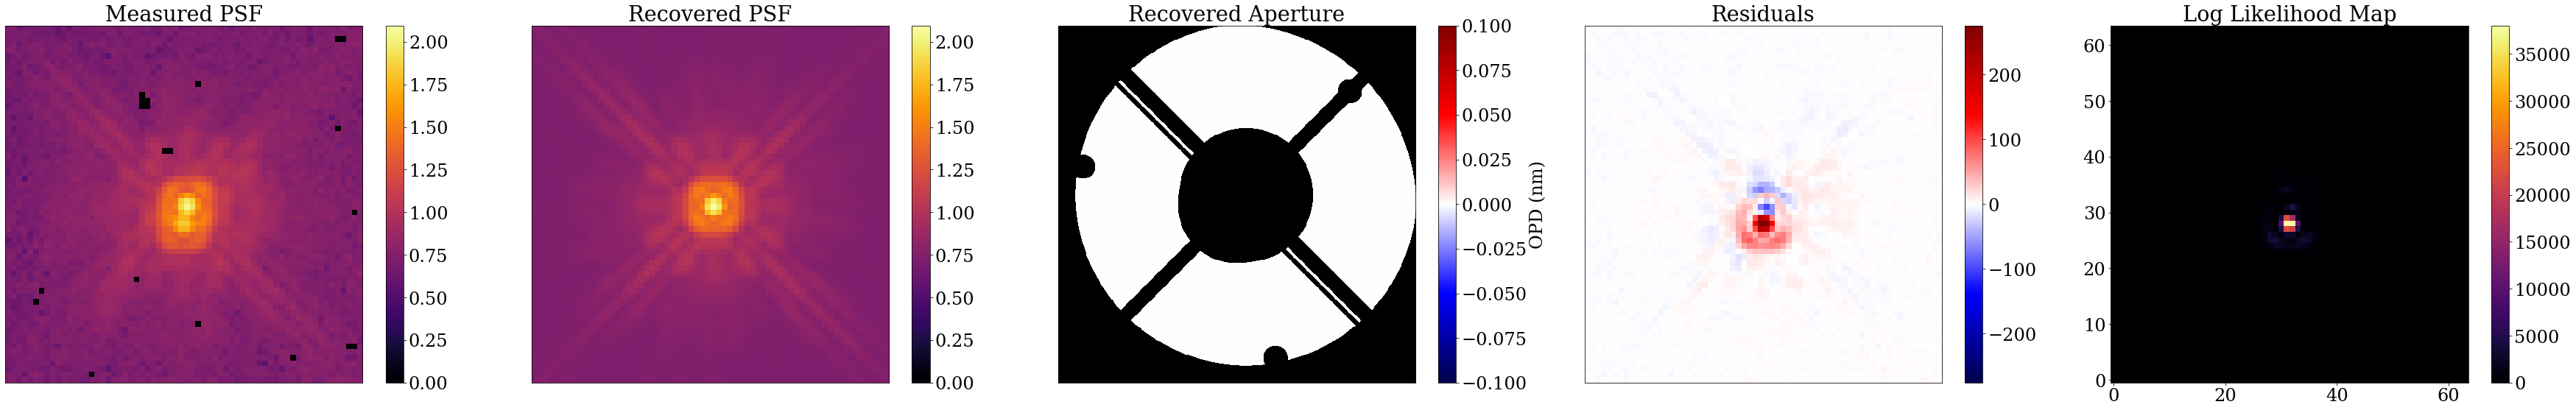

In [9]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [10]:
#potato

In [11]:
#plot_spectra(model_single, models[-1], exposures_single)

In [12]:
def tree_mul(spec, val):
    return jtu.tree_map(lambda x: x*val, spec)

def tree_sum(spec, val):
    return jtu.tree_map(lambda x: x+val, spec)


def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = tree_sum(param_dict["positions"], np.array([x,y]))
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)


"""def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):
    fluxes = dlu.fluxes_from_contrast(flux, contrast)
    injected_params = ModelParams({
        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),
        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),
        "positions": np.asarray([x,y]),
        "position_angle": theta,
        "separation": r
    })
    return injected_params.inject(initial_params)
"""

'def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):\n    fluxes = dlu.fluxes_from_contrast(flux, contrast)\n    injected_params = ModelParams({\n        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),\n        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),\n        "positions": np.asarray([x,y]),\n        "position_angle": theta,\n        "separation": r\n    })\n    return injected_params.inject(initial_params)\n'

In [13]:
binary_params = extract_binary_params(models[-1], exposures_binary, 0., 0., 0., 0., 0., 1.)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [14]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [15]:
#things = {"primary_spectrum": opt(4e-6, 0), "secondary_spectrum": opt(4e-6, 0)}#, "contrast": opt(1e-8, 10)}
things = {"fluxes": opt(5e-11, 0)}#, "contrast": opt(5e-11, 10)}

@zdx.filter_jit
@zdx.filter_value_and_grad(list(things.keys()))
def binary_loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

def binary_optimise(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]
    
    optim, opt_state = zdx.get_optimiser(
        params, paths, optimisers
    )

    losses, models = [], []
    for i in (range(niter)):
        loss, grads = binary_loss_fn(params,exposures, model)
        #grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
        updates, opt_state = optim.update(grads, opt_state)
        params = zdx.apply_updates(params, updates)

        models.append(params)
        losses.append(loss)
    
    return losses, models

In [16]:
binary_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f64[26]},
    'bias':
    {'n8yj59glq': f64[]},
    'cold_mask_rot':
    {'F110W': f64[]},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'cold_mask_shift':
    {'n8yj59glq': f64[2]},
    'outer_radius':
    1.146,
    'positions':
    {'n8yj59glq': f64[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_shear':
    {'F110W': f64[2]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f64[5]},
    'spider_width':
    0.0924,
    'primary_spectrum':
    {'U20081_F110W': f64[5]},
    'secondary_spectrum':
    {'U20081_F110W': f64[5]},
    'fluxes':
    {'U20081_F110W': 0.0},
    'contrast':
    {'F110W': 1.0},
    'separation':
    0.0,
    'position_angle':
    0.0
  }
)

In [17]:
x_vals = np.linspace(-5, 5, 4)
y_vals = np.linspace(-5, 5, 4)
theta_vals = np.arange(4)*np.pi/2#np.linspace(0, 2*np.pi, 4)
r_vals = np.asarray([1.5, 3])#np.linspace(0, 5, 2)

min_loss = np.inf
best_params = None

for x in x_vals:
    for y in y_vals:
        for theta in theta_vals:
            for r in r_vals:
                binary_params = extract_binary_params(models[-1], exposures_binary, x, y, theta, r, 0., 1.)
                #binary_params = extract_binary_params(models[-1], exposures_binary, 0, 0, 0, 0, 0., 1.)#np.log10(0.5), 1.)
                losses, bms = binary_optimise(binary_params, model_binary, exposures_binary, things, 10)
                print(losses[-1])
                if losses[-1] < min_loss and min_loss != 0.0:
                    min_loss = losses[-1]
                    best_params = bms[-1]
                

29739663.537304856
29254984.651673764
29746002.71162388
29304342.81815794
29752946.147307344
29355117.701814763
29760452.032123175
29406773.60414338
26370603.740853116
25773258.969877698
26362913.093855817
25744538.332950793
26356560.202231146
25725748.482662316
26351558.81571883
25716859.862269346
29810219.745466083
29394073.779879145
29809887.272239562
29379611.339702696
29810086.27162102
29366397.29039129
29810821.140806917
29354631.399578214
29196617.56485121
30482861.18519966
29183130.676680624
30458730.424414508
29169466.492795356
30433088.3953014
29155664.39090175
30406001.95217437
20336004.472205896
17542129.115203857
20307805.4128036
17449795.17175456
20280051.935821783
17358584.157386467
20252826.507748466
17268678.021843623
8590421.02329973
5797402.265080657
8565270.92794972
5737105.497165362
8540887.810022652
5680958.019133393
8517353.958975026
5629308.552233835
16314151.062099105
14298064.95917035
16357837.264976228
14450374.060702058
16400886.214243982
14602265.930061145


In [18]:
best_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f64[26]},
    'bias':
    {'n8yj59glq': f64[]},
    'cold_mask_rot':
    {'F110W': f64[]},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'cold_mask_shift':
    {'n8yj59glq': f64[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f64[]},
    'outer_radius':
    1.146,
    'position_angle':
    f64[],
    'positions':
    {'n8yj59glq': f64[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_shear':
    {'F110W': f64[2]},
    'primary_spectrum':
    {'U20081_F110W': f64[5]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f64[5]},
    'separation':
    f64[],
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f64[5]},
    'spider_width':
    0.0924
  }
)

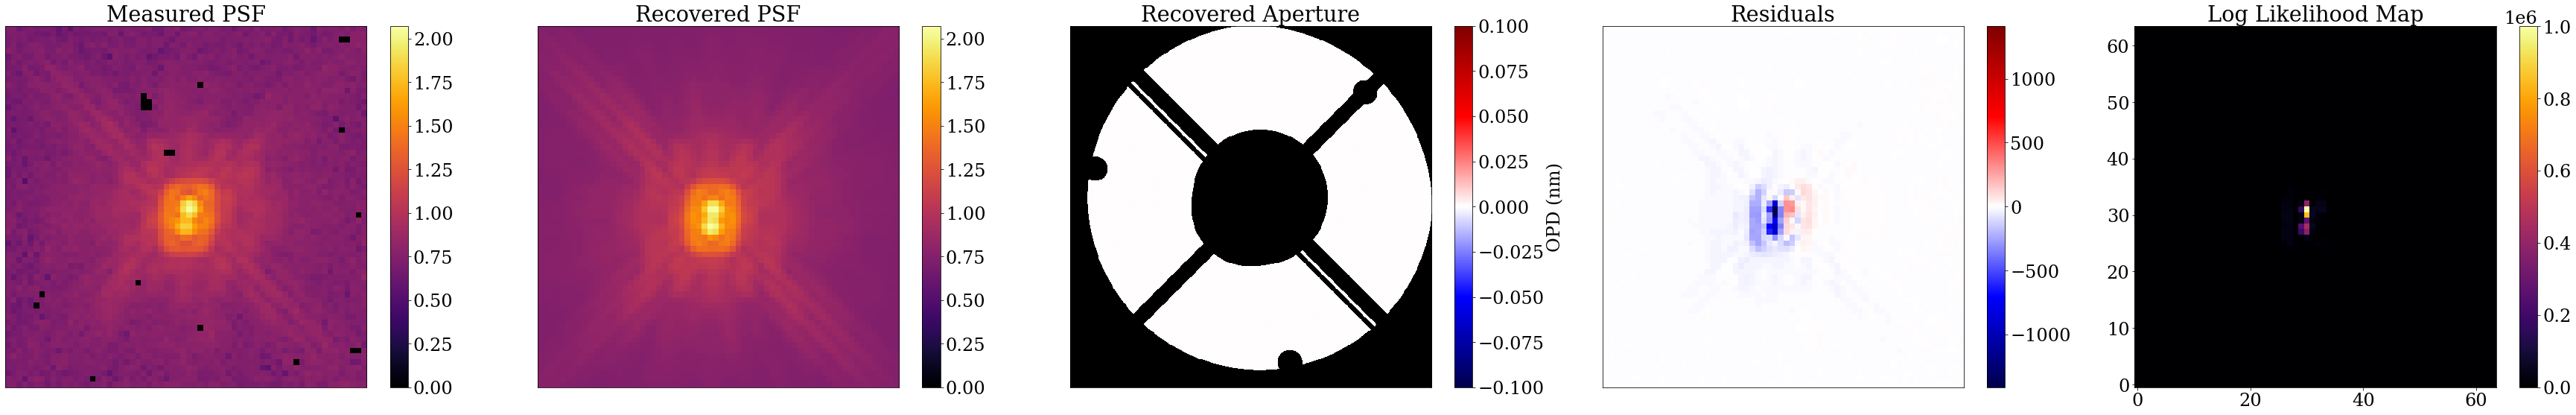

In [19]:
plot_comparison(model_binary, best_params, exposures_binary)

In [20]:
g = 5e-3
things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*100, 0),
    "separation": opt(g*30, 0),
    "position_angle": opt(g*1e-2, 10),
    "primary_spectrum": opt(g*50, 20),
    "secondary_spectrum": opt(g*50, 20),#, (20, 1.5)),
    "cold_mask_shift": opt(g*50, 60),
    "cold_mask_rot": opt(g*10, 60),
    "aberrations": opt(g*10,30),#, (150, g*0.2)),
    "bias": opt(g*20, 40)
}
groups = list(things.keys())


In [21]:
losses, models = optimise(best_params, set_array(model_binary), exposures_binary, things, 150)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[6871716.4706721 , -300684.00164797],
       [-300684.00164797, 5537494.36428452]], dtype=float64), 'separation': Array([[-404701.4320531]], dtype=float64), 'position_angle': Array([[0.]], dtype=float64), 'primary_spectrum': Array([[27911086.02784314,  2834148.30572782,  9142960.11212972,
         2015461.89596968,  5739310.28110972],
       [ 2834148.30572782,  5051256.4548971 ,  1458627.37966835,
         3119765.31279778,  1090046.73142261],
       [ 9142960.11212972,  1458627.37966835,  4389849.83843421,
         1137513.16174031,  3145345.09513305],
       [ 2015461.89596968,  3119765.31279778,  1137513.16174031,
         2331079.91813177,   905447.99486659],
       [ 5739310.28110972,  1090046.73142261,  3145345.09513305,
          905447.99486659,  2435792.34520826]], dtype=float64), 'secondary_spectrum': Array([[27911086.02784314,  2834148.30572782,  9142960.11212972,
         2015461.89596968,  5739310.28110972],
       [ 2834148.30572782,  5

  0%|          | 0/150 [00:00<?, ?it/s]

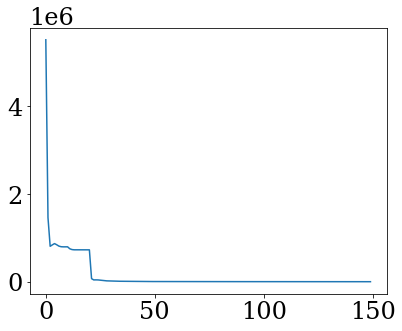

In [22]:
plt.plot(losses)

In [23]:
losses[-1]

Array(2222.05783647, dtype=float64)

9


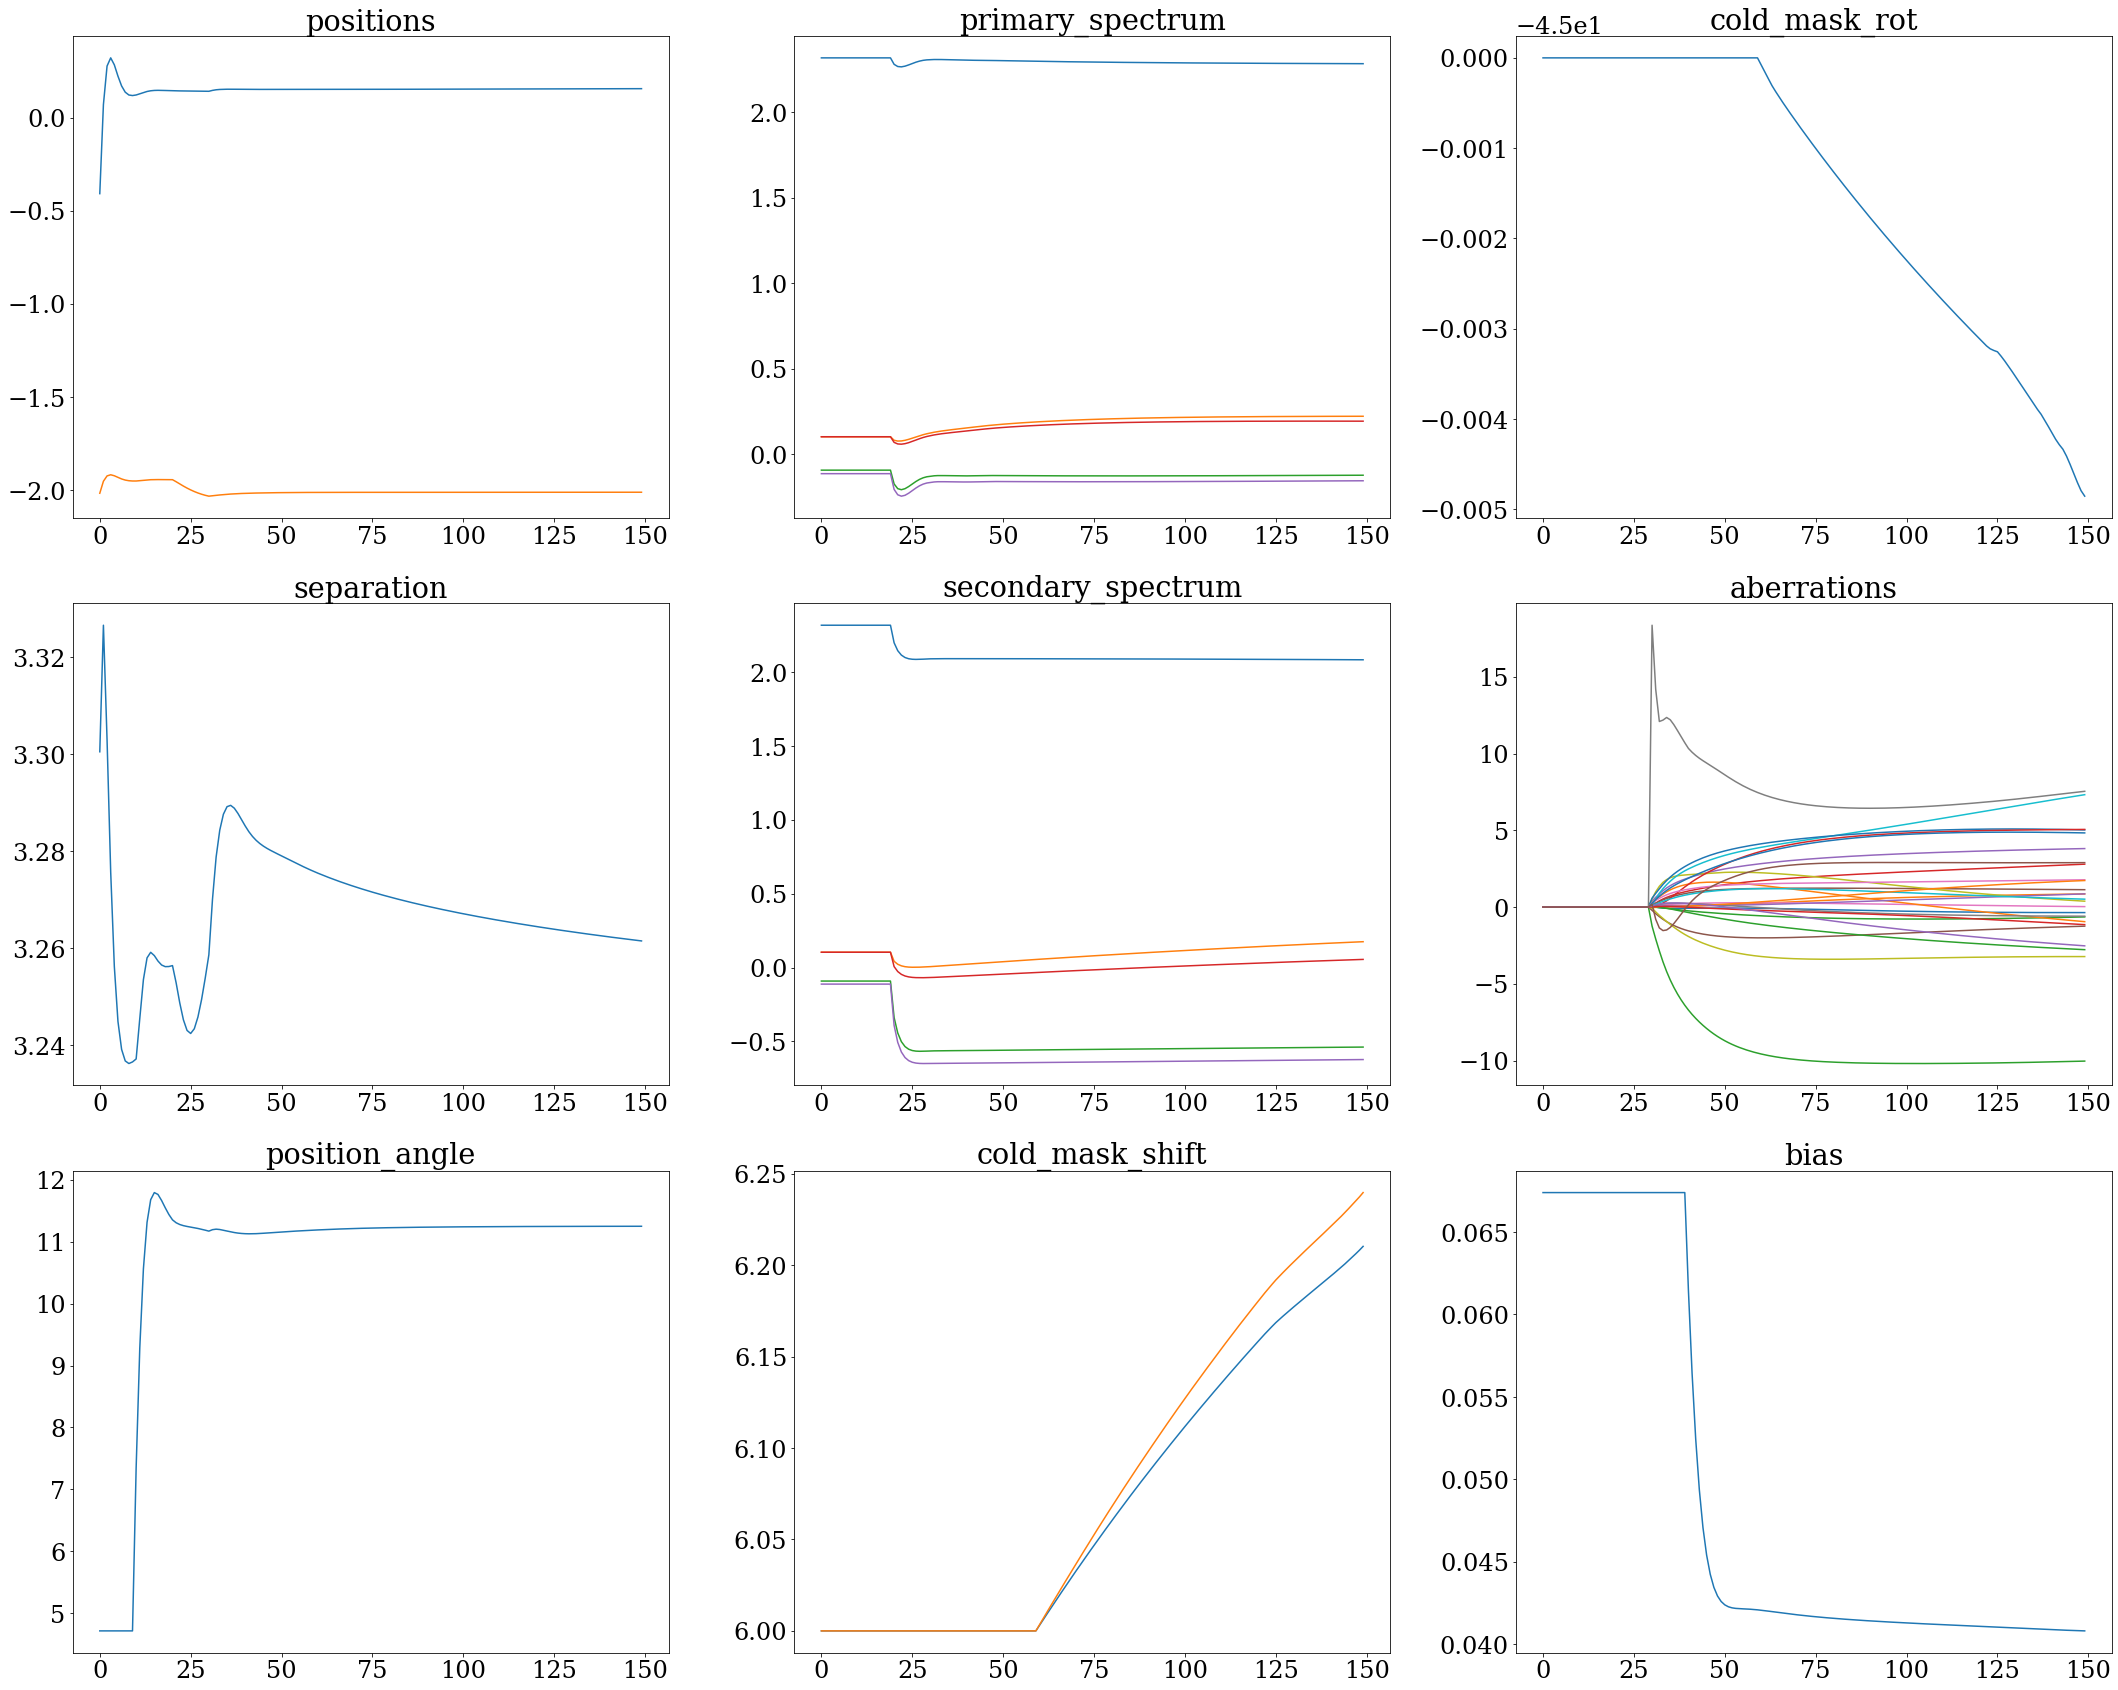

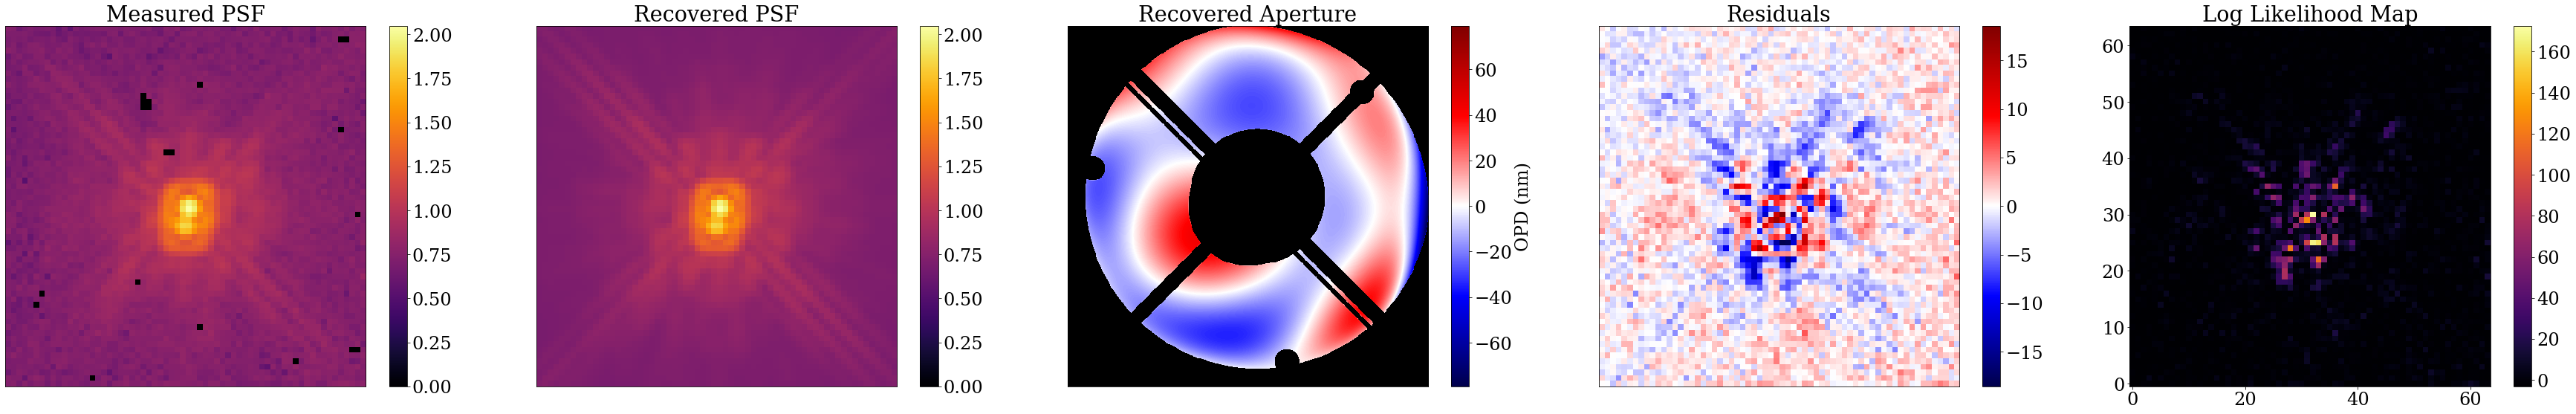

In [24]:
plot_params(models, groups, xw = 3)
plot_comparison(model_binary, models[-1], exposures_binary)

In [25]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ -0.35750359,   0.855938  ,  -0.63945924,   2.79489126,
           3.81127966,   1.13326736,   0.03157093,   7.54088486,
           0.38450757,   7.32076343,   5.02390001,  -0.94828296,
         -10.02930494,   5.05822591,   0.8618746 ,  -1.24142975,
           1.7790472 ,  -0.59308551,  -3.22196052,   0.51659632,
           4.83166324,   1.72956195,  -2.77237561,  -1.14115238,
          -2.52362892,   2.89558206], dtype=float64)},
 'bias': {'n8yj59glq': Array(0.04081931, dtype=float64)},
 'cold_mask_rot': {'F110W': Array(-45.00485294, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8yj59glq': Array([6.21031982, 6.23974142], dtype=float64)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.03722372, dtype=float64))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.25063344, dtype=floa

Text(0, 0.5, 'Relative Spectral Intensity')

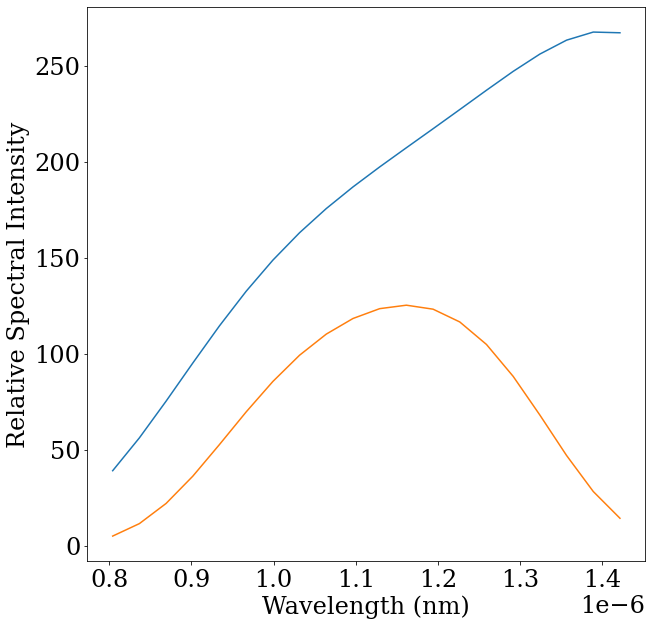

In [26]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [27]:
rc = True
fishers = calc_fishers(models[-1].inject(model_binary), exposures_binary, groups, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [28]:
fishers

{'n8yj59glq': {'positions': Array([[1912826.91847716,  -71727.10635895],
         [ -71727.10635895, 1667552.84560324]], dtype=float64),
  'separation': Array([[455198.86263078]], dtype=float64),
  'position_angle': Array([[1523.43094514]], dtype=float64),
  'primary_spectrum': Array([[10325216.35276816,  2390557.97737685,  3526383.20549583,
           1594602.98205598,  2257530.76271345],
         [ 2390557.97737685,   767876.94913504,   862877.45854968,
            469321.71182199,   553848.74656863],
         [ 3526383.20549583,   862877.45854968,  1230178.767781  ,
            569388.97529949,   788882.41290312],
         [ 1594602.98205598,   469321.71182199,   569388.97529949,
            294757.56852439,   365669.69386139],
         [ 2257530.76271345,   553848.74656863,   788882.41290312,
            365669.69386139,   506166.59794909]], dtype=float64),
  'secondary_spectrum': Array([[3150687.53217107,  200804.67901699,  585935.26544639,
            97049.65610621,  257817.0839

In [29]:
aberration_names = [dlu.zernike_name(x) for x in range(40)]
poly_names = ["poly "+ x for x in ["0", "1", "2", "3", "4"]]

In [30]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ -0.35750359,   0.855938  ,  -0.63945924,   2.79489126,
           3.81127966,   1.13326736,   0.03157093,   7.54088486,
           0.38450757,   7.32076343,   5.02390001,  -0.94828296,
         -10.02930494,   5.05822591,   0.8618746 ,  -1.24142975,
           1.7790472 ,  -0.59308551,  -3.22196052,   0.51659632,
           4.83166324,   1.72956195,  -2.77237561,  -1.14115238,
          -2.52362892,   2.89558206], dtype=float64)},
 'bias': {'n8yj59glq': Array(0.04081931, dtype=float64)},
 'cold_mask_rot': {'F110W': Array(-45.00485294, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8yj59glq': Array([6.21031982, 6.23974142], dtype=float64)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.03722372, dtype=float64))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.25063344, dtype=floa

In [31]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0]

Array(0.02562056, dtype=float64)

In [32]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0]

Array(0.00148217, dtype=float64)

In [33]:
np.diag(np.sqrt(np.linalg.inv(fishers['n8yj59glq']['secondary_spectrum'])))

Array([0.00560255, 0.00795034, 0.06240396, 0.01476979, 0.07599022],      dtype=float64)

In [35]:
#potato

In [ ]:

def make_psf_model(modelparams, fishers):

    #@zdx.filter_jit
    def psf_model(data, model):

        params = {
            "primary_spectrum": {},
            "secondary_spectrum": {},
            "positions": {},
            #"position_angle": 0., 
            #"separation": 0. , 
            #"cold_mask_shift": {},
            #"aberrations": {},
        }

        for exp in exposures_binary:

            pos_mean = modelparams.get(exp.map_param("positions"))
            pos_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['positions']))))

            primary_mean = modelparams.get(exp.map_param("primary_spectrum"))
            primary_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['primary_spectrum']))))

            secondary_mean = modelparams.get(exp.map_param("secondary_spectrum"))
            secondary_std = np.diag(np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['secondary_spectrum']))))

            position_angle = npy.sample("position_raw", dist.Normal(0,1))
            separation = npy.sample("separation_raw", dist.Normal(0,1))
            X = npy.sample("x_raw", dist.Normal(0,1))
            Y = npy.sample("y_raw", dist.Normal(0,1))

            primary_spectrum = npy.sample("primary_raw", dist.Normal(np.zeros(5), np.ones(5)))
            secondary_spectrum = npy.sample("secondary_raw", dist.Normal(np.zeros(5), np.ones(5)))

            params["position_angle"] = npy.deterministic("Position Angle", modelparams.get("position_angle") + position_angle*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0])

            params["separation"] = npy.deterministic("Separation", modelparams.get("separation") + separation* np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0])

            #params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([npy.sample("Cold X", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[0][0] + modelparams.get(exp.map_param("cold_mask_shift"))[0], npy.sample("Cold Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[1][1] + modelparams.get(exp.map_param("cold_mask_shift"))[1]])

            
            
            params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([npy.deterministic("X", pos_mean[0]+ X*pos_std[0]), npy.deterministic("Y", pos_mean[1]+ Y*pos_std[1])])

            params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")] = np.asarray([
                npy.deterministic("primary " +poly_names[x], primary_mean[i] + primary_spectrum[i]*primary_std[i]) for i, x in enumerate(range(0,5))    
            ])

            params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")] = np.asarray([
                npy.deterministic("secondary " +poly_names[x], secondary_mean[i] + secondary_spectrum[i]*secondary_std[i]) for i, x in enumerate(range(0,5))    
            ])




            #params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([
            #    npy.sample(aberration_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['aberrations'][i][i]) + modelparams.get(exp.map_param("aberrations"))[i] for i, x in enumerate(range(4,30))
                
            #])

        params = ModelParams(params)

        
        
        with npy.plate("data", size=len(data.data.flatten())):

            mdl = params.inject(model)
            model_data = data.fit(mdl, data).flatten()
            img, err, bad = data.data.flatten(), data.err.flatten(), data.bad.flatten()
            image = np.where(bad, 0, img)
            error = np.where(bad, 1e5, err)
            
            image_d = dist.Normal(image, error)
            return npy.sample("psf", image_d, obs=np.where(bad,0,model_data))
    
    return psf_model



sampler = npy.infer.MCMC(
    npy.infer.NUTS(make_psf_model(models[-1], jtu.tree_map(lambda x: np.abs(x), fishers)), 
                   init_strategy=npy.infer.init_to_mean,
                    dense_mass=False),
    num_warmup=10,
    num_samples=10,
    #num_chains=6,
    #chain_method='vectorized',
    progress_bar=True,
    chain_method = zdx.filter_jit,
    #jit_model_args=True,
)

sampler.run(jr.PRNGKey(0),exposures_binary[0], model_binary)

sampler.print_summary()

chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="blue")
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
fig.savefig("new_turbo_32_adj.png")
#plt.close()

plt.show()

sample: 100%|██████████| 20/20 [16:00<00:00, 48.03s/it, 255 steps of size 1.58e-02. acc. prob=0.87] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
    position_raw     -3.27      1.04     -3.39     -4.85     -1.74      3.26      2.15
  primary_raw[0]    -10.56      3.03    -10.51    -14.04     -5.56      2.86      2.38
  primary_raw[1]      2.53      0.45      2.52      1.70      3.08      4.22      1.52
  primary_raw[2]     -3.29      0.73     -3.40     -4.31     -2.15      4.37      0.99
  primary_raw[3]     -2.66      0.59     -2.65     -3.34     -1.61      3.62      1.72
  primary_raw[4]      2.34      0.80      2.28      0.94      3.48      4.75      0.97
secondary_raw[0]    -21.17      5.01    -22.86    -25.70    -10.90      3.52      1.67
secondary_raw[1]     13.93      2.25     14.42      9.25     15.96      4.15      1.44
secondary_raw[2]      2.25      1.01      2.03      1.10      4.11      3.08      2.12
secondary_raw[3]      8.74      1.28      9.15      5.86     10.37      5.54      1.14
secondary_raw[4]      5.44      1.12      

ValueError: All arrays must be of the same length

Parameter Position Angle in chain numpyro chain is not constrained
Parameter Separation in chain numpyro chain is not constrained
Parameter X in chain numpyro chain is not constrained
Parameter Y in chain numpyro chain is not constrained
Parameter primary poly 0 in chain numpyro chain is not constrained
Parameter primary poly 1 in chain numpyro chain is not constrained
Parameter primary poly 2 in chain numpyro chain is not constrained
Parameter primary poly 3 in chain numpyro chain is not constrained
Parameter primary poly 4 in chain numpyro chain is not constrained
Parameter secondary poly 0 in chain numpyro chain is not constrained
Parameter secondary poly 1 in chain numpyro chain is not constrained
Parameter secondary poly 2 in chain numpyro chain is not constrained
Parameter secondary poly 3 in chain numpyro chain is not constrained
Parameter secondary poly 4 in chain numpyro chain is not constrained


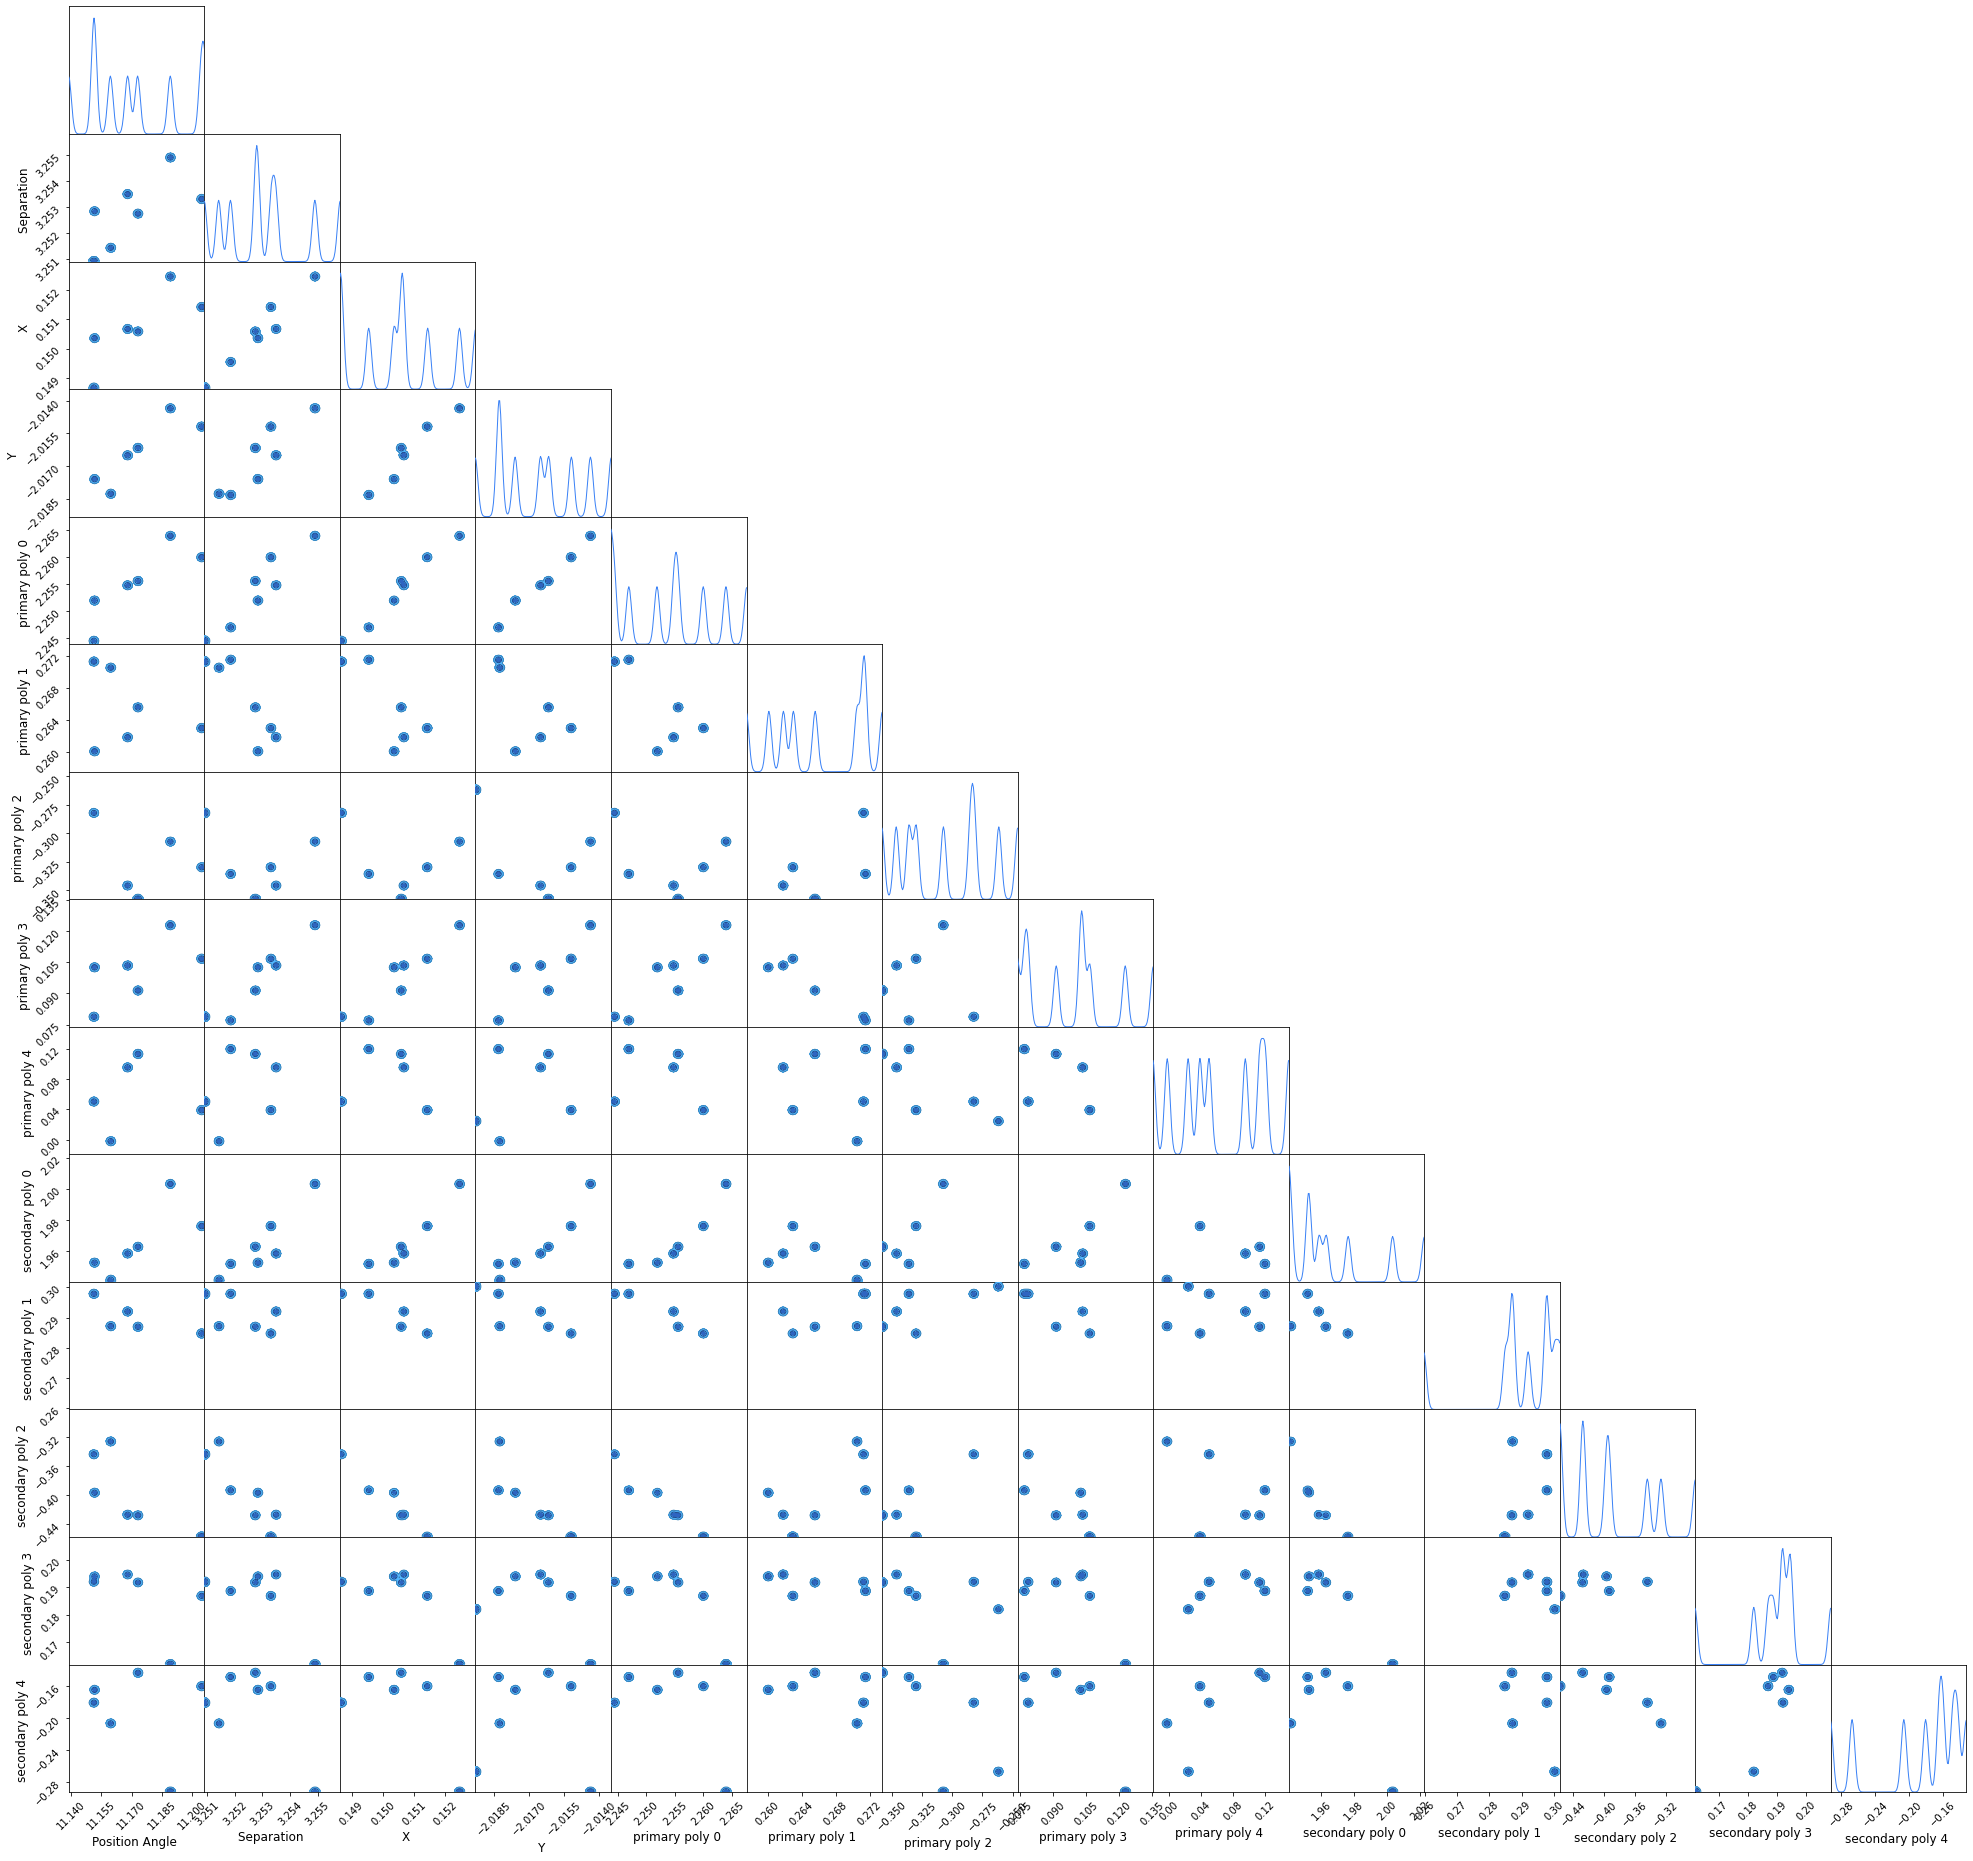

In [38]:
chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="blue", var_names=["~primary_raw", "~secondary_raw", "~position_raw", "~separation_raw", "~x_raw", "~y_raw"])
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
#fig.savefig("new_turbo_32_adj.png")
#plt.close()

plt.show()